<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week8_early_fusion_BOW_POS_text_statistics_en_10genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week8: This notebook is to do early fusion of Bag-of-words, POS and text statistics using min_max scale.

Situation: English only (=multi-class) genre detection using SMOTE.
Split: StratifiedKfold.


### Preprocess: import files

In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.1 MB/s 


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


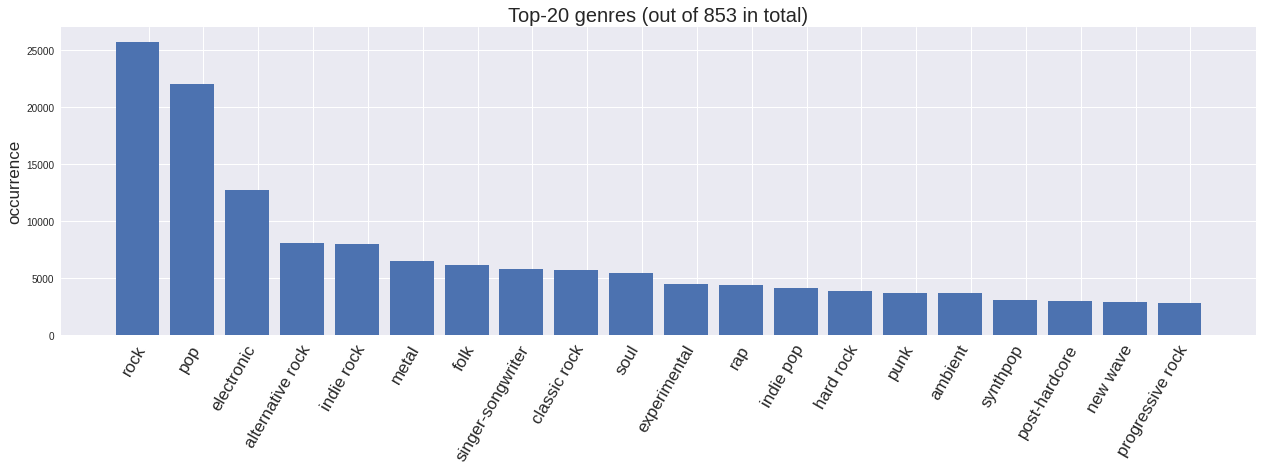

In [6]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [7]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [8]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [9]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [10]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [11]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


Number of genres: 15


Counter({'alternative rock': 338,
         'classic rock': 167,
         'electronic': 953,
         'experimental': 180,
         'folk': 863,
         'hard rock': 195,
         'indie pop': 672,
         'indie rock': 1081,
         'metal': 157,
         'pop': 5179,
         'punk': 382,
         'rap': 978,
         'rock': 1449,
         'singer-songwriter': 695,
         'soul': 1288})

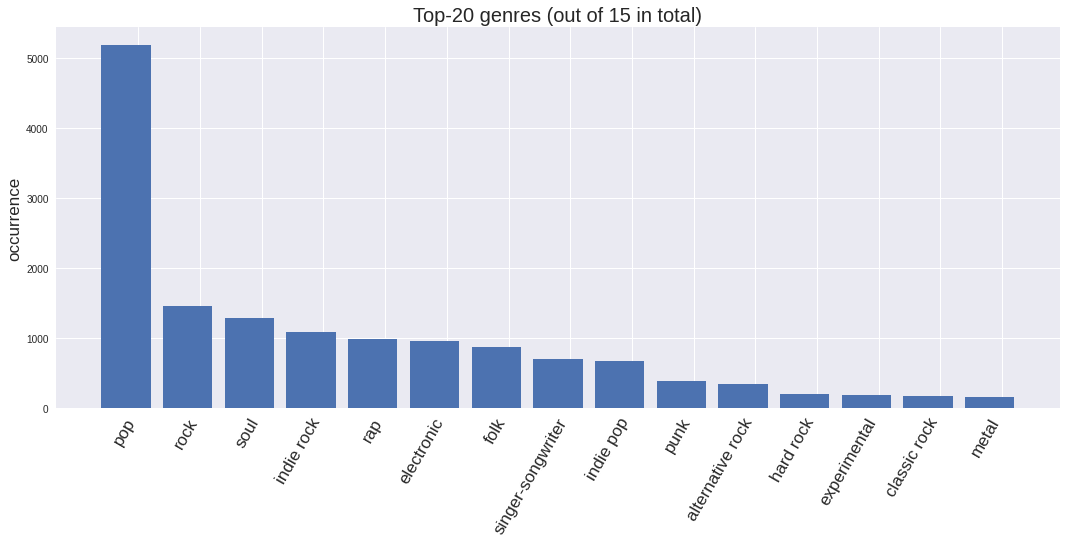

In [12]:
analyze_genre_tag_df(df_genre_by_lang,20)

In [13]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Number of genres: 10


Counter({'electronic': 953,
         'folk': 863,
         'indie pop': 672,
         'indie rock': 1081,
         'pop': 5179,
         'punk': 382,
         'rap': 978,
         'rock': 1449,
         'singer-songwriter': 695,
         'soul': 1288})

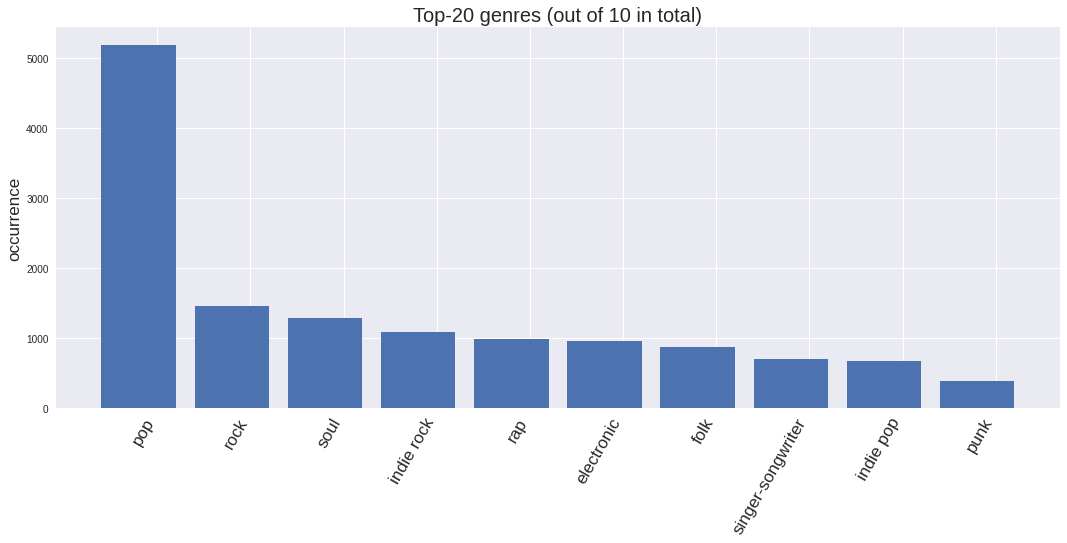

In [14]:
analyze_genre_tag_df(df_genre_by_lang,20)

Reindex

In [15]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [16]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [17]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

### This time, apply stemming and normilize words

In [18]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [19]:
text = "This is a test sentence. Yo, 123 today2022"
text= text.replace(',', '')
text = text.replace('.', '')
text_tokens = [stemmer.stem(word) for word in text.split(' ') ]
print(text_tokens)

#text_tokens_alphabet = []
#for word in text.split(' '):
#  temp_word = stemmer.stem(word)
#  print("temp:", temp_word)
#  if temp_word.isalpha():
#    text_tokens_alphabet.append(temp_word)
text_tokens_alphabet = [stemmer.stem(word) for word in text.split(' ') if word.isalpha()]
print(text_tokens_alphabet)

['thi', 'is', 'a', 'test', 'sentenc', 'yo', '123', 'today2022']
['thi', 'is', 'a', 'test', 'sentenc', 'yo']


This study removes "," and "." to get only alphabets.

In [20]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      lyric_document=[' '.join([stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]) ]
      #print(lyric_document)
          #for text in words]
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [21]:
#index 5001 ~ 7988
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      lyric_document=[' '.join([stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]) ]
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [22]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [23]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65


In [24]:
df_genre_by_lang.shape[0]

13540

### Analysis1: length of lyrics

In [25]:
df_genre_by_lang["length"] = 0
df_genre_by_lang["number_of_token"] = 0
for idx, row in df_genre_by_lang.loc[0:df_genre_by_lang.shape[0]].iterrows():
  #print(row['lyric'])
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_token"] = len(row['lyric'].split(' '))
  #print(len(row['lyric']))
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "length"] = len(row['lyric'])

In [26]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173
...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431


In [27]:
#get average string length for pop
for genre in final_genre_list:
  print(genre, " - ave. length:",
        round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'length'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    , 0)
  )

pop  - ave. length: 1294.0
rock  - ave. length: 942.0
soul  - ave. length: 1179.0
indie rock  - ave. length: 864.0
rap  - ave. length: 1969.0
electronic  - ave. length: 912.0
folk  - ave. length: 848.0
singer-songwriter  - ave. length: 869.0
indie pop  - ave. length: 964.0
punk  - ave. length: 836.0


### Analysis2: Count the number of unique vocaburaries.

In [28]:
df_genre_by_lang["vocabulary"] = 0
for idx, row in df_genre_by_lang.loc[0:df_genre_by_lang.shape[0]].iterrows():
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "vocabulary"] =  len(set(row['lyric'].split(' ')) )

In [29]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91
...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115


In [30]:
for genre in final_genre_list:
  print(genre, " - ave. number_of_token:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,0)
  )

pop  - ave. number_of_token: 290.0
rock  - ave. number_of_token: 208.0
soul  - ave. number_of_token: 264.0
indie rock  - ave. number_of_token: 190.0
rap  - ave. number_of_token: 432.0
electronic  - ave. number_of_token: 200.0
folk  - ave. number_of_token: 187.0
singer-songwriter  - ave. number_of_token: 191.0
indie pop  - ave. number_of_token: 214.0
punk  - ave. number_of_token: 180.0


In [31]:
#get the average number of vocabs for each genre
for genre in final_genre_list:
  print(genre, " - ave. vocabulary:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'vocabulary'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,0)
  )


pop  - ave. vocabulary: 87.0
rock  - ave. vocabulary: 77.0
soul  - ave. vocabulary: 86.0
indie rock  - ave. vocabulary: 73.0
rap  - ave. vocabulary: 161.0
electronic  - ave. vocabulary: 68.0
folk  - ave. vocabulary: 80.0
singer-songwriter  - ave. vocabulary: 77.0
indie pop  - ave. vocabulary: 77.0
punk  - ave. vocabulary: 75.0


In [32]:
#get the vocaburary ratio
#get the average number of vocavuraries for each genre
for genre in final_genre_list:
  print(genre, " - unique vocabulary ratio:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'vocabulary'])
    /sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])
    ,2)
  )

pop  - unique vocabulary ratio: 0.3
rock  - unique vocabulary ratio: 0.37
soul  - unique vocabulary ratio: 0.33
indie rock  - unique vocabulary ratio: 0.38
rap  - unique vocabulary ratio: 0.37
electronic  - unique vocabulary ratio: 0.34
folk  - unique vocabulary ratio: 0.43
singer-songwriter  - unique vocabulary ratio: 0.41
indie pop  - unique vocabulary ratio: 0.36
punk  - unique vocabulary ratio: 0.42


In [33]:
df_genre_by_lang["unique_vocab_ratio"] = df_genre_by_lang["vocabulary"]/df_genre_by_lang["number_of_token"]

In [34]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75,0.156250
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38,0.214689
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98,0.248101
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81,0.637795
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91,0.526012
...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57,0.678571
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101,0.275956
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138,0.467797
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115,0.266821


### Analysis3: count number of line(:=sentenses) per song in each genre 

In [35]:
for genre in final_genre_list:
  print(genre, " - ave. number of line per song:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_line'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,2)
  )

pop  - ave. number of line per song: 59.47
rock  - ave. number of line per song: 42.71
soul  - ave. number of line per song: 53.93
indie rock  - ave. number of line per song: 39.08
rap  - ave. number of line per song: 69.86
electronic  - ave. number of line per song: 42.8
folk  - ave. number of line per song: 35.82
singer-songwriter  - ave. number of line per song: 39.02
indie pop  - ave. number of line per song: 42.16
punk  - ave. number of line per song: 36.04


### Analysis4: Get ave. number of tokens per line. (Check if a sentense is long or short)

In [36]:
for genre in final_genre_list:
  print(genre, " - ave. tokens per line:",
    round(
     sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])   
    /sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_line'])
    ,2)
  )

pop  - ave. tokens per line: 4.87
rock  - ave. tokens per line: 4.86
soul  - ave. tokens per line: 4.9
indie rock  - ave. tokens per line: 4.86
rap  - ave. tokens per line: 6.19
electronic  - ave. tokens per line: 4.68
folk  - ave. tokens per line: 5.23
singer-songwriter  - ave. tokens per line: 4.9
indie pop  - ave. tokens per line: 5.07
punk  - ave. tokens per line: 5.0


In [37]:
df_genre_by_lang["tokens_per_line"] = df_genre_by_lang["number_of_token"]/df_genre_by_lang["number_of_line"]


In [38]:
df_genre_by_lang[ df_genre_by_lang.index == 12278]

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line
12278,u9j4JrXmBLN8UC6t,electronic,en,yeah mate welcom to plaistow flex out,0,37,7,7,1.0,inf


### Get Part-of-Speech Feature

In [39]:
import nltk
#from nltk.corpus import state_union
#from nltk.tokenize import PunktSentenceTokenizer

#tokenizer = PunktSentenceTokenizer(df_genre_by_lang['lyric'])

from nltk import pos_tag
from nltk import RegexpParser
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Below code, next time we don't need "total_token" anymore. We counted as number_of_tokens

In [40]:
target_tags =set(['NN', 'NNS' , 'NNP' , 'NNPS' \
              ,'VB', 'VBG' , 'VBD' , 'VBN', 'VBP', 'VBZ' \
              ,'RB', 'RBR' , 'RBS' \
              ,'JJ', 'JJR' , 'JJS' ])

In [41]:
from collections import Counter

for index, row in df_genre_by_lang.loc[0:5000].iterrows():
  tokens_tag = pos_tag(row['lyric'].split())
  #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'total_token'] = int(len(tokens_tag))
  counts =  Counter( tag for word,  tag in tokens_tag)
  for tag, value in counts.items():
    if tag in target_tags:
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], tag] = int(value)

In [42]:
for index, row in df_genre_by_lang.loc[5001:10000].iterrows():
  tokens_tag = pos_tag(row['lyric'].split())
  #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'total_token'] = int(len(tokens_tag))
  
  counts =  Counter( tag for word,  tag in tokens_tag)
  for tag, value in counts.items():
    if tag in target_tags:
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], tag] = int(value)

In [43]:
for index, row in df_genre_by_lang.loc[10000:df_genre_by_lang.shape[0]].iterrows():
  tokens_tag = pos_tag(row['lyric'].split())
  #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'total_token'] = int(len(tokens_tag))
  
  counts =  Counter( tag for word,  tag in tokens_tag)
  for tag, value in counts.items():
    if tag in target_tags:
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], tag] = int(value)

In [44]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,...,VBN,NNS,RBR,VBZ,VBG,JJR,RBS,JJS,NNP,NNPS
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75,0.156250,5.274725,...,3.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38,0.214689,4.916667,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98,0.248101,5.337838,...,4.0,1.0,NaN,10.0,11.0,NaN,NaN,NaN,NaN,NaN
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81,0.637795,6.350000,...,1.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91,0.526012,5.580645,...,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57,0.678571,4.666667,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101,0.275956,4.880000,...,10.0,7.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138,0.467797,8.676471,...,1.0,2.0,1.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115,0.266821,6.630769,...,11.0,3.0,NaN,13.0,1.0,1.0,NaN,NaN,NaN,NaN


Group by Nouns, Verbs, Adjetives, Adverbs

In [45]:
for index, row in df_genre_by_lang.loc[0:df_genre_by_lang.shape[0]].iterrows():
  #print(row)
  noun_sum = np.nansum( [row['NN'], row['NNS'] , row['NNP'] , row['NNPS'] ] )
  verb_sum = np.nansum ( [ row['VB'] , row['VBG'] , row['VBD'] , row['VBN'], row['VBP'], row['VBZ'] ] )
  adv_sum = np.nansum( [row['RB'], row['RBR'] , row['RBS']  ] )
  adj_sum = np.nansum( [row['JJ'], row['JJR'] , row['JJS']] )

  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'noun_ratio'] = round(noun_sum/row["number_of_token"],3)
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'verb_ratio'] = round(verb_sum/row["number_of_token"],3)
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'adverb_ratio'] = round(adv_sum/row["number_of_token"],3)
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], 'adjective_ratio'] = round(adj_sum/row["number_of_token"],3)

Drop old coulmns

In [46]:
noun_columns =['NN', 'NNS' , 'NNP' , 'NNPS' ]
verb_columns =['VB', 'VBG' , 'VBD' , 'VBN', 'VBP', 'VBZ' ]
adv_columns =['RB', 'RBR' , 'RBS' ]
adj_columns =['JJ', 'JJR' , 'JJS' ]
df_genre_by_lang = df_genre_by_lang.drop(columns=noun_columns)
df_genre_by_lang = df_genre_by_lang.drop(columns=verb_columns)
df_genre_by_lang = df_genre_by_lang.drop(columns=adv_columns)
df_genre_by_lang = df_genre_by_lang.drop(columns=adj_columns)

In [47]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75,0.156250,5.274725,0.150,0.294,0.071,0.046
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38,0.214689,4.916667,0.266,0.254,0.023,0.136
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98,0.248101,5.337838,0.182,0.218,0.043,0.073
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81,0.637795,6.350000,0.283,0.142,0.008,0.079
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91,0.526012,5.580645,0.225,0.231,0.052,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57,0.678571,4.666667,0.131,0.321,0.071,0.048
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101,0.275956,4.880000,0.276,0.205,0.052,0.137
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138,0.467797,8.676471,0.247,0.156,0.037,0.092
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115,0.266821,6.630769,0.202,0.278,0.039,0.072


###  Train and Test flow

Step1: Kfold Stratified Split

Step2: For X_train, get Bag-of-Words feature using TF-IDF.

Step3: clf.fit(X_train, y_train)

Step4: transform X_test['lyric'] to TF-IDF

Step5: Predict by, clf_predict = clf.predict(X_test_tf-idf)

Step6: Compare (clf_predict, y_test)

### After POS is done, apply min-max scaler so that every column is between 0 and 1.

The transformation is given by:
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

In [48]:
df_genre_by_lang[df_genre_by_lang["tokens_per_line"] == float("inf") ].index

Int64Index([5851, 12278], dtype='int64')

In [49]:
#drop rows  
df_genre_by_lang = df_genre_by_lang.drop(
    df_genre_by_lang[df_genre_by_lang["tokens_per_line"] == float("inf") ].index
)

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#scaler.fit(df_genre_by_lang["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"])

df_genre_by_lang[["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"]] = \
  scaler.fit_transform(df_genre_by_lang[["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"]])

In [51]:
scaler.data_max_

array([ 1223.        , 18999.        ,  4332.        ,   484.        ,
          32.33333333])

In [52]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,0.072891,0.103943,0.108952,0.149688,0.156250,0.125548,0.150,0.294,0.071,0.046
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,0.027846,0.036425,0.038862,0.072765,0.214689,0.113977,0.266,0.254,0.023,0.136
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,0.073
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,0.014742,0.028823,0.027296,0.162162,0.637795,0.160298,0.283,0.142,0.008,0.079
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,0.013104,0.017104,0.017349,0.112266,0.678571,0.105897,0.131,0.321,0.071,0.048
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,0.059787,0.082880,0.082582,0.203742,0.275956,0.112792,0.276,0.205,0.052,0.137
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,0.026208,0.065935,0.066158,0.280665,0.467797,0.235482,0.247,0.156,0.037,0.092
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,0.051597,0.098189,0.097617,0.232848,0.266821,0.169371,0.202,0.278,0.039,0.072


In [53]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.fillna(0)
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [54]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,0.072891,0.103943,0.108952,0.149688,0.156250,0.125548,0.150,0.294,0.071,0.046
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,0.027846,0.036425,0.038862,0.072765,0.214689,0.113977,0.266,0.254,0.023,0.136
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,0.073
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,0.014742,0.028823,0.027296,0.162162,0.637795,0.160298,0.283,0.142,0.008,0.079
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13533,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,0.013104,0.017104,0.017349,0.112266,0.678571,0.105897,0.131,0.321,0.071,0.048
13534,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,0.059787,0.082880,0.082582,0.203742,0.275956,0.112792,0.276,0.205,0.052,0.137
13535,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,0.026208,0.065935,0.066158,0.280665,0.467797,0.235482,0.247,0.156,0.037,0.092
13536,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,0.051597,0.098189,0.097617,0.232848,0.266821,0.169371,0.202,0.278,0.039,0.072


#### Step1

In [55]:
def StratifiedKFold_feature_and_df(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [56]:
feature_list = ["lyric", "number_of_line",	"length",	"number_of_token"\
                       ,"vocabulary",	"unique_vocab_ratio" ,	"tokens_per_line" \
                      , "noun_ratio", "verb_ratio", "adverb_ratio", "adjective_ratio"]

splits = StratifiedKFold_feature_and_df( df_genre_by_lang, feature_list, 'genres')

TRAIN: [    0     1     3 ... 13535 13536 13537] TEST: [    2     4     5 ... 13524 13530 13533]
TRAIN: [    0     2     4 ... 13533 13534 13537] TEST: [    1     3     7 ... 13528 13535 13536]
TRAIN: [    0     1     2 ... 13535 13536 13537] TEST: [    8    14    22 ... 13519 13529 13534]
TRAIN: [    0     1     2 ... 13535 13536 13537] TEST: [   10    12    15 ... 13521 13523 13532]
TRAIN: [    1     2     3 ... 13534 13535 13536] TEST: [    0     6    11 ... 13527 13531 13537]


In [57]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10830, 11)
(10830,)
(2708, 11)
(2708,)


In [58]:
split0['X_test'][split0['X_test']["tokens_per_line"] == float("inf") ]

,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio


#### Step2 get bag-of-words & apply TF-IDF

In [59]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(split0['X_train']['lyric']).toarray()
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
X_train_tfidf.shape

(10830, 21127)

In [61]:
df_X_train_tfidf = pd.DataFrame(X_train_tfidf
                                ,index = split0['X_train'].index
                              , columns=tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
df_X_train_tfidf

,aaa,aaaaaaaaah,aaaaaaah,aaaaand,aaaaay,aaaah,aaaahhh,aaaahooo,aaah,aaahhhhhhh,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# merge three dataframes into one
df_X_train_tfidf = pd.concat([split0['X_train'] , df_X_train_tfidf]
                             , join='inner' ,axis=1)

In [64]:
df_X_train_tfidf = df_X_train_tfidf.drop(columns=['lyric'])
df_X_train_tfidf

,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
0,0.072891,0.103943,0.108952,0.149688,0.156250,0.125548,0.150,0.294,0.071,0.046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.027846,0.036425,0.038862,0.072765,0.214689,0.113977,0.266,0.254,0.023,0.136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014742,0.028823,0.027296,0.162162,0.637795,0.160298,0.283,0.142,0.008,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.033579,0.054585,0.050197,0.147609,0.327434,0.124937,0.177,0.314,0.119,0.115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.103194,0.140421,0.137405,0.559252,0.451078,0.107328,0.300,0.227,0.023,0.113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13532,0.041769,0.090429,0.086514,0.270270,0.347258,0.188621,0.282,0.183,0.034,0.110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13534,0.059787,0.082880,0.082582,0.203742,0.275956,0.112792,0.276,0.205,0.052,0.137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13535,0.026208,0.065935,0.066158,0.280665,0.467797,0.235482,0.247,0.156,0.037,0.092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13536,0.051597,0.098189,0.097617,0.232848,0.266821,0.169371,0.202,0.278,0.039,0.072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Step2,3,4

In [65]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn import metrics

In [66]:
split0['X_test']

,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio
2,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,0.073
4,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,0.064
5,i wa alon i wa made of stone you took me home ...,0.052416,0.039381,0.039787,0.112266,0.314917,0.043712,0.122,0.249,0.149,0.061
9,again the burden of lose rest upon my shoulder...,0.042588,0.087051,0.089521,0.172557,0.217172,0.192076,0.245,0.220,0.013,0.126
20,onli been three week and a bag of speed from j...,0.018018,0.028876,0.029146,0.164241,0.607407,0.136868,0.319,0.185,0.007,0.074
...,...,...,...,...,...,...,...,...,...,...,...
13515,like the legend of the phoenix all end with be...,0.027846,0.040173,0.041869,0.110187,0.294737,0.125647,0.232,0.147,0.032,0.058
13520,mr telephon man someth wrong with my line when...,0.063063,0.080294,0.077492,0.195426,0.281977,0.095807,0.352,0.186,0.035,0.102
13524,can you imagin what it would be like we never ...,0.015561,0.026553,0.026602,0.137214,0.556452,0.145909,0.137,0.298,0.048,0.032
13530,love of my life hurt me broken my heart and no...,0.017199,0.028612,0.029840,0.099792,0.369565,0.148987,0.123,0.203,0.109,0.014


In [67]:
#for idx, document in enumerate(split0['X_test']['lyric'])
for idx, row in df_genre_by_lang.loc[0:100].iterrows():
  if row["lyric"].__contains__("pipe"):
    print(" idx: ",  idx)
    print(row["lyric"])
    print("number_of_line:",row["number_of_line"])

 idx:  49
even the rat know when troubl gonna come to the edg of the citi see the littl guy run i hear spring is nice in canada mayb the men up on capitol hill need a littl less jack and a littl more jill you can have my stereo even though the race may never be won i can lay like a dandi heavi in the sun take a love song and beautifi waoh i hear the word but the mean get lost a game it depend on who the ball get toss the same ball anyway me know cut me loos or take me on you can play you can pay the piper all night long some good home even though the race may never be won i can lay like a dandi heavi in the sun take a love song and beautifi waoh line in second if you can hear me now then halfway there just a jump from your window fli nake through the air take a long hard look
number_of_line: 0.02620802620802621
 idx:  66
oh oh yeah i get loud when you put that pipe down pipe down pipe down i wanna celebr you right now right now right now got me for you all across town cross town cross 

Cristina Aguilera's pipe down is index 66.

### 1.Multinomial NM

In [68]:
#Before SMOTE
clf_mnb_no_SMOTE = MultinomialNB().fit(df_X_train_tfidf, split0['y_train'])

In [69]:
X_test_tfidf = tfidf_vectorizer.transform(split0['X_test']['lyric']).toarray()

Concatenate X_test_tfidf and split0['X_test']

In [70]:
df_X_test_tfidf = pd.DataFrame(X_test_tfidf
                                ,index = split0['X_test'].index
                              , columns=tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [71]:
df_X_test_tfidf = pd.concat([split0['X_test'] , df_X_test_tfidf]
                             , join='inner' ,axis=1)

In [72]:
df_X_test_tfidf

,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
2,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,i wa alon i wa made of stone you took me home ...,0.052416,0.039381,0.039787,0.112266,0.314917,0.043712,0.122,0.249,0.149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,again the burden of lose rest upon my shoulder...,0.042588,0.087051,0.089521,0.172557,0.217172,0.192076,0.245,0.220,0.013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,onli been three week and a bag of speed from j...,0.018018,0.028876,0.029146,0.164241,0.607407,0.136868,0.319,0.185,0.007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13515,like the legend of the phoenix all end with be...,0.027846,0.040173,0.041869,0.110187,0.294737,0.125647,0.232,0.147,0.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13520,mr telephon man someth wrong with my line when...,0.063063,0.080294,0.077492,0.195426,0.281977,0.095807,0.352,0.186,0.035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13524,can you imagin what it would be like we never ...,0.015561,0.026553,0.026602,0.137214,0.556452,0.145909,0.137,0.298,0.048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13530,love of my life hurt me broken my heart and no...,0.017199,0.028612,0.029840,0.099792,0.369565,0.148987,0.123,0.203,0.109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_X_test_tfidf = df_X_test_tfidf.drop(columns=['lyric'])
df_X_test_tfidf

,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
2,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,0.073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,0.064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.052416,0.039381,0.039787,0.112266,0.314917,0.043712,0.122,0.249,0.149,0.061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.042588,0.087051,0.089521,0.172557,0.217172,0.192076,0.245,0.220,0.013,0.126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.018018,0.028876,0.029146,0.164241,0.607407,0.136868,0.319,0.185,0.007,0.074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13515,0.027846,0.040173,0.041869,0.110187,0.294737,0.125647,0.232,0.147,0.032,0.058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13520,0.063063,0.080294,0.077492,0.195426,0.281977,0.095807,0.352,0.186,0.035,0.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13524,0.015561,0.026553,0.026602,0.137214,0.556452,0.145909,0.137,0.298,0.048,0.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13530,0.017199,0.028612,0.029840,0.099792,0.369565,0.148987,0.123,0.203,0.109,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#df_X_test_tfidf.columns.to_series()[np.isinf(df_X_test_tfidf).any()]
#df_X_test_tfidf.index[np.isinf(df_X_test_tfidf).any(1)]

df_X_test_tfidf = df_X_test_tfidf.drop(
    8493
)
#df_X_test_tfidf[df_X_test_tfidf["tokens_per_line"] == float("inf")]

In [75]:
split0['y_test'] = split0['y_test'].drop(8493)

In [76]:
# Predictions
predicted_mnb_no_SMOTE = clf_mnb_no_SMOTE.predict(df_X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_mnb_no_SMOTE) )

                   precision    recall  f1-score   support

       electronic       0.00      0.00      0.00       190
             folk       0.00      0.00      0.00       172
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.39      1.00      0.56      1035
             punk       0.00      0.00      0.00        77
              rap       1.00      0.10      0.18       195
             rock       0.00      0.00      0.00       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.00      0.00      0.00       258

         accuracy                           0.39      2707
        macro avg       0.14      0.11      0.07      2707
     weighted avg       0.22      0.39      0.23      2707



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_mnb_no_SMOTE)

0.10974358974358975

In [78]:
type(df_X_train_tfidf.to_numpy())

numpy.ndarray

In [79]:
type(split0['y_train'])

pandas.core.series.Series

In [80]:
#If SVM SMOTE takes time, do this
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(df_X_train_tfidf.to_numpy(), split0['y_train']) 
print(sorted(Counter(y_resampled).items()))

[('electronic', 4143), ('folk', 4143), ('indie pop', 4143), ('indie rock', 4143), ('pop', 4143), ('punk', 4143), ('rap', 4143), ('rock', 4143), ('singer-songwriter', 4143), ('soul', 4143)]


In [81]:
clf_mnb_SMOTE = MultinomialNB().fit(X_resampled, y_resampled)
predicted_mnb_SMOTE = clf_mnb_SMOTE.predict(df_X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_mnb_SMOTE) )

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


                   precision    recall  f1-score   support

       electronic       0.21      0.14      0.16       190
             folk       0.17      0.34      0.23       172
        indie pop       0.09      0.17      0.12       135
       indie rock       0.19      0.13      0.16       216
              pop       0.63      0.32      0.42      1035
             punk       0.27      0.27      0.27        77
              rap       0.62      0.78      0.70       195
             rock       0.16      0.11      0.13       290
singer-songwriter       0.16      0.21      0.18       139
             soul       0.21      0.48      0.29       258

         accuracy                           0.31      2707
        macro avg       0.27      0.30      0.27      2707
     weighted avg       0.38      0.31      0.32      2707



In [82]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_mnb_SMOTE)

0.29676005487640067

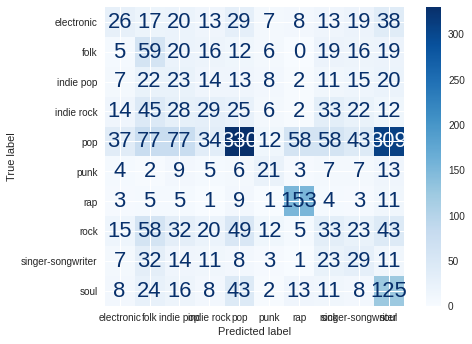

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_mnb_SMOTE
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
plt.show()

In [84]:
df_X_test_tfidf[df_X_test_tfidf.index == 66]

,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio,...,흘러가는,흘러갔지만,흥분되는,흥분되어,흥분을,흥분해,힘겨워,힘들어할,힙합씬에,ﬁnd
66,0.051597,0.113868,0.110571,0.328482,0.330595,0.197214,0.197,0.187,0.142,0.076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
predicted_mnb_SMOTE_christina = clf_mnb_SMOTE.predict(df_X_test_tfidf[df_X_test_tfidf.index == 66])
predicted_mnb_SMOTE_christina

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array(['pop'], dtype='<U17')

##### Still Christina's pipe down was classified as "rap" instead of Pop.

### 2.Support Vector Machine

In [ ]:
from sklearn import svm

clf_svm_NO_SMOTE = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_NO_SMOTE.fit(df_X_train_tfidf, split0['y_train'])

SVC(gamma='auto', kernel='linear')

Took 34 min.

In [86]:
split0['X_test']

,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line,noun_ratio,verb_ratio,adverb_ratio,adjective_ratio
2,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588,0.182,0.218,0.043,0.073
4,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434,0.225,0.231,0.052,0.064
5,i wa alon i wa made of stone you took me home ...,0.052416,0.039381,0.039787,0.112266,0.314917,0.043712,0.122,0.249,0.149,0.061
9,again the burden of lose rest upon my shoulder...,0.042588,0.087051,0.089521,0.172557,0.217172,0.192076,0.245,0.220,0.013,0.126
20,onli been three week and a bag of speed from j...,0.018018,0.028876,0.029146,0.164241,0.607407,0.136868,0.319,0.185,0.007,0.074
...,...,...,...,...,...,...,...,...,...,...,...
13515,like the legend of the phoenix all end with be...,0.027846,0.040173,0.041869,0.110187,0.294737,0.125647,0.232,0.147,0.032,0.058
13520,mr telephon man someth wrong with my line when...,0.063063,0.080294,0.077492,0.195426,0.281977,0.095807,0.352,0.186,0.035,0.102
13524,can you imagin what it would be like we never ...,0.015561,0.026553,0.026602,0.137214,0.556452,0.145909,0.137,0.298,0.048,0.032
13530,love of my life hurt me broken my heart and no...,0.017199,0.028612,0.029840,0.099792,0.369565,0.148987,0.123,0.203,0.109,0.014


In [ ]:
predicted_svm_NO_SMOTE = clf_svm_NO_SMOTE.predict(df_X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_svm_NO_SMOTE) )

                   precision    recall  f1-score   support

       electronic       0.26      0.06      0.10       190
             folk       0.21      0.17      0.19       172
        indie pop       0.00      0.00      0.00       135
       indie rock       0.23      0.14      0.17       216
              pop       0.48      0.93      0.63      1035
             punk       0.58      0.09      0.16        77
              rap       0.90      0.76      0.83       195
             rock       0.23      0.12      0.16       290
singer-songwriter       0.30      0.06      0.11       139
             soul       0.29      0.02      0.04       258

         accuracy                           0.46      2707
        macro avg       0.35      0.24      0.24      2707
     weighted avg       0.38      0.46      0.37      2707



In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_svm_NO_SMOTE)

0.23676957110446267

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
print(predicted_svm_NO_SMOTE)

Apply SMOTE

In [ ]:
from sklearn import svm
from imblearn.over_sampling import SVMSMOTE
#After SMOTE
sm = SVMSMOTE(random_state=42)

X_res, y_res = sm.fit_resample(df_X_train_tfidf.to_numpy(), split0['y_train'])
print(sorted(Counter(y_res).items()))
#clf_mnb_SMOTE = MultinomialNB().fit(X_resampled, y_resampled)


In [ ]:
X_res.shape

In [ ]:
clf_svm_SMOTE = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_SMOTE.fit(X_resampled, y_resampled)

In [ ]:
predicted_svm_SMOTE = clf_svm_SMOTE.predict(split0['X_test'])
print(metrics.classification_report(split0['y_test'], predicted_svm_SMOTE) )

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_svm_SMOTE)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_svm_SMOTE
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

In [ ]:
print(predicted_svm_SMOTE)

### Stochastic Gradient Decent algorithm to achieve linear SVM
, loss = "epsilon_insensitive"

In [ ]:
X_resampled.shape

(41430, 6)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import balanced_accuracy_score


#clf_sdg_SMOTE = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
#clf_sdg_SMOTE.fit(X_resampled, y_resampled)

losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
classifier = []
#scores = []
for loss in losses:
    clf = SGDClassifier(loss=loss, penalty="l2", max_iter=1000)
    clf.fit(X_resampled, y_resampled)
    predicted_sdg_SMOTE = clf.predict(split0['X_test'])
    print(metrics.classification_report(split0['y_test'], predicted_sdg_SMOTE) )
    print("balanced_accuracy: ", balanced_accuracy_score(split0['y_test'], predicted_sdg_SMOTE))
    classifier.append(predicted_sdg_SMOTE)
    #scores.append(clf.score(testX, testY))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

       electronic       0.00      0.00      0.00       190
             folk       0.00      0.00      0.00       173
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.60      0.29      0.39      1036
             punk       0.04      0.97      0.07        76
              rap       0.75      0.42      0.54       195
             rock       0.00      0.00      0.00       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.00      0.00      0.00       258

         accuracy                           0.17      2708
        macro avg       0.14      0.17      0.10      2708
     weighted avg       0.28      0.17      0.19      2708

balanced_accuracy:  0.16799113167534221


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

       electronic       0.33      0.10      0.15       190
             folk       0.21      0.05      0.08       173
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.00      0.00      0.00      1036
             punk       0.07      0.03      0.04        76
              rap       0.69      0.48      0.57       195
             rock       0.00      0.00      0.00       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.10      0.93      0.18       258

         accuracy                           0.13      2708
        macro avg       0.14      0.16      0.10      2708
     weighted avg       0.10      0.13      0.07      2708

balanced_accuracy:  0.1588718373223223


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

       electronic       0.40      0.01      0.02       190
             folk       0.00      0.00      0.00       173
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.58      0.02      0.04      1036
             punk       0.33      0.01      0.03        76
              rap       0.51      0.71      0.59       195
             rock       0.11      0.90      0.20       290
singer-songwriter       0.06      0.03      0.04       139
             soul       0.00      0.00      0.00       258

         accuracy                           0.16      2708
        macro avg       0.20      0.17      0.09      2708
     weighted avg       0.31      0.16      0.08      2708

balanced_accuracy:  0.16784932649756582


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

       electronic       0.25      0.01      0.01       190
             folk       0.00      0.00      0.00       173
        indie pop       0.05      0.89      0.10       135
       indie rock       0.00      0.00      0.00       216
              pop       0.60      0.00      0.01      1036
             punk       0.00      0.00      0.00        76
              rap       0.31      0.81      0.45       195
             rock       0.00      0.00      0.00       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.00      0.00      0.00       258

         accuracy                           0.10      2708
        macro avg       0.12      0.17      0.06      2708
     weighted avg       0.27      0.10      0.04      2708

balanced_accuracy:  0.17021760048075837
                   precision    recall  f1-score   support

       electronic       0.00      0.00      0.00       190
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predicted_sdg_SMOTE = clf_sdg_SMOTE.predict(split0['X_test'])
print(metrics.classification_report(split0['y_test'], predicted_sdg_SMOTE) )

                   precision    recall  f1-score   support

       electronic       0.11      0.12      0.12       190
             folk       0.00      0.00      0.00       173
        indie pop       0.00      0.00      0.00       135
       indie rock       0.00      0.00      0.00       216
              pop       0.47      0.01      0.01      1036
             punk       0.00      0.00      0.00        76
              rap       0.32      0.55      0.40       195
             rock       0.12      0.80      0.20       290
singer-songwriter       0.00      0.00      0.00       139
             soul       0.08      0.04      0.06       258

         accuracy                           0.14      2708
        macro avg       0.11      0.15      0.08      2708
     weighted avg       0.23      0.14      0.07      2708



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Count Rhymes